In [1]:
# All necessary import 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,RobustScaler,LabelBinarizer,StandardScaler
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout 
from keras.models import Sequential 
from keras.layers import Input
from keras.models import Model
import itertools
from itertools import cycle

In [2]:
# Let's get our data
KDDtrain_path = '..\\nsl-kdd\KDDTrain+.txt'
KDDtest_path = '..\\nsl-kdd\KDDTest+.txt'

KDDtrain_df = pd.read_csv(KDDtrain_path, header=None)
KDDtest_df = pd.read_csv(KDDtest_path,header=None)

# Let's concatenate both dataframes
KDD_df = pd.concat([KDDtrain_df, KDDtest_df],ignore_index=True)


In [3]:
# The data doesn't have a header let's take care of it
columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate'
,'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])


In [4]:
# Let's assign the name of the columns
KDD_df.columns = columns


In [5]:
# let's count the number of unique flags in the dataset


len(KDD_df['service'].unique())

70

# Data preprocessing

* We will use a few different approaches while preprocessing for our CNN model. 

In [6]:
# Let's remove the last column since it's not necessary
KDD_df = KDD_df.iloc[:,:-1] # level of difficulty column
KDD_df.shape 

(148517, 42)

In [7]:
# Changing attack labels to their respective attack class
# Let's rename our outcome column to label
KDD_df.rename(columns={'outcome':'label'},inplace=True)

def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)      
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

In [8]:
change_label(KDD_df)
KDD_df.label.value_counts()

label
normal    77054
Dos       53387
Probe     14077
R2L        3880
U2R         119
Name: count, dtype: int64

In [9]:
# creating a dataframe with multi-class labels (Dos,Probe,R2L,U2R,normal)
multi_data = KDD_df.copy()
multi_label = pd.DataFrame(multi_data.label)

In [10]:
# Using Robust scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

numeric_col = multi_data.select_dtypes(include='number').columns
data = standardization(multi_data,numeric_col)

In [11]:
# label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)

LabEnc = preprocessing.LabelEncoder()
enc_label = multi_label.apply(LabEnc.fit_transform) # encode the labels
multi_data['intrusion'] = enc_label # add the new label column to the dataframe
multi_data.drop(labels= [ 'label'], axis=1, inplace=True) # drop the old label column

multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion
0,-0.112481,tcp,ftp_data,SF,-0.007346,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.849240,-0.813554,-0.278736,0.077981,-0.280650,-0.597720,-0.584813,-0.267151,-0.406815,4
1,-0.112481,udp,other,SF,-0.007409,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-1.065006,-1.192968,2.657874,2.378421,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,4
2,-0.112481,tcp,private,S0,-0.007436,-0.004614,-0.01468,-0.085488,-0.010403,-0.094071,...,-0.840250,-0.969783,-0.175697,-0.472829,-0.280650,1.736012,1.742295,-0.422074,-0.406815,0
3,-0.112481,tcp,http,SF,-0.007394,-0.002413,-0.01468,-0.085488,-0.010403,-0.094071,...,1.218511,1.038878,-0.433294,-0.375627,0.086408,-0.527708,-0.561542,-0.422074,-0.376989,4
4,-0.112481,tcp,http,SF,-0.007400,-0.004501,-0.01468,-0.085488,-0.010403,-0.094071,...,1.218511,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148512,-0.112481,tcp,smtp,SF,-0.007290,-0.004524,-0.01468,-0.085488,-0.010403,-0.094071,...,0.193625,0.413961,-0.124178,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,4
148513,-0.112481,tcp,http,SF,-0.007378,-0.004361,-0.01468,-0.085488,-0.010403,-0.094071,...,1.218511,1.038878,-0.433294,-0.440428,-0.188885,-0.574382,-0.584813,-0.422074,-0.406815,4
148514,-0.112481,tcp,http,SF,0.002646,-0.002369,-0.01468,-0.085488,-0.010403,0.899396,...,1.218511,1.038878,-0.433294,-0.472829,-0.280650,-0.597720,-0.584813,-0.205182,-0.198035,0
148515,-0.112481,udp,domain_u,SF,-0.007429,-0.004603,-0.01468,-0.085488,-0.010403,-0.094071,...,1.191540,1.016560,-0.381775,-0.472829,-0.280650,-0.597720,-0.584813,-0.422074,-0.406815,4


In [12]:
# let's print the equivalent labels from our label encoder
LabEnc.classes_

array(['Dos', 'Probe', 'R2L', 'U2R', 'normal'], dtype=object)

In [13]:
# one-hot-encoding for categorical features
multi_data = pd.get_dummies(multi_data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")  


In [14]:
v = multi_data.columns
# let's save the names of the columns in a file
np.savetxt("..\data\\features.txt",v,fmt='%s')

In [110]:
y_train_multi= multi_data[['intrusion']] # labels
X_train_multi= multi_data.drop(labels=['intrusion'], axis=1) # features

print('X_train has shape:',X_train_multi.shape,'\ny_train has shape:',y_train_multi.shape)

X_train has shape: (148517, 122) 
y_train has shape: (148517, 1)


In [111]:
# one-hot-encoding for multi-class labels

y_train_multi = LabelBinarizer().fit_transform(y_train_multi) 
y_train_multi 

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

In [112]:
# converting to numpy array
X_train_multi = X_train_multi.astype(np.float32)
y_train_multi = y_train_multi.astype(np.float32)

# splitting the dataset 80% for training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_train_multi,y_train_multi, test_size=0.20, random_state=42)

# reshaping the data to fit the model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print('X_train has shape:',X_train.shape,'\ny_train has shape:',X_test.shape)

X_train has shape: (118813, 122, 1) 
y_train has shape: (29704, 122, 1)


# Neural Network approach

In [113]:
# Let's build our model

model = Sequential()
# input layer and first layer with 50 neurons
model.add(Conv1D(32, 3, padding="same",input_shape = (X_train.shape[1], 1), activation='relu'))
model.add(MaxPool1D(pool_size=(4)))  
model.add(Dropout(0.2))
model.add(Conv1D(32, 3, padding="same", activation='relu'))
model.add(MaxPool1D(pool_size=(4)))  
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units=50))
# output layer with softmax activation
model.add(Dense(units=5,activation='softmax'))

In [114]:
# defining loss function, optimizer, metrics and then compiling model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [115]:
# summary of model layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 122, 32)           128       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 30, 32)            0         
 g1D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 30, 32)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 30, 32)            3104      
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 7, 32)             0         
 g1D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 7, 32)            

In [116]:
# training the model on training dataset
history = model.fit(X_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
20/20 [==============================] - 5s 217ms/step - loss: 1.1235 - accuracy: 0.6144 - val_loss: 0.8141 - val_accuracy: 0.8052
Epoch 2/100
20/20 [==============================] - 5s 250ms/step - loss: 0.7117 - accuracy: 0.7969 - val_loss: 0.5086 - val_accuracy: 0.8567
Epoch 3/100
20/20 [==============================] - 4s 203ms/step - loss: 0.5059 - accuracy: 0.8485 - val_loss: 0.3726 - val_accuracy: 0.8798
Epoch 4/100
20/20 [==============================] - 4s 206ms/step - loss: 0.4095 - accuracy: 0.8754 - val_loss: 0.3105 - val_accuracy: 0.8983
Epoch 5/100
20/20 [==============================] - 4s 203ms/step - loss: 0.3616 - accuracy: 0.8870 - val_loss: 0.2781 - val_accuracy: 0.9121
Epoch 6/100
20/20 [==============================] - 4s 206ms/step - loss: 0.3261 - accuracy: 0.8992 - val_loss: 0.2532 - val_accuracy: 0.9216
Epoch 7/100
20/20 [==============================] - 4s 214ms/step - loss: 0.2997 - accuracy: 0.9062 - val_loss: 0.2350 - val_accuracy: 0.9251

In [117]:
# predicting target attribute on testing dataset
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

929/929 [==============================] - 2s 2ms/step - loss: 0.0766 - accuracy: 0.9732
Test results - Loss: 0.07660660892724991 - Accuracy: 97.32359051704407%


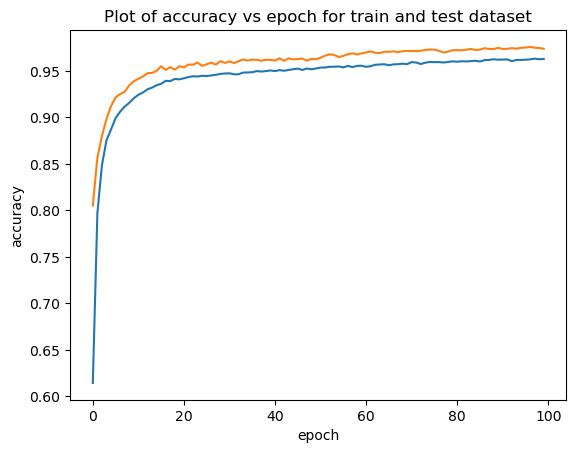

In [118]:
# Plot of accuracy vs epoch for train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

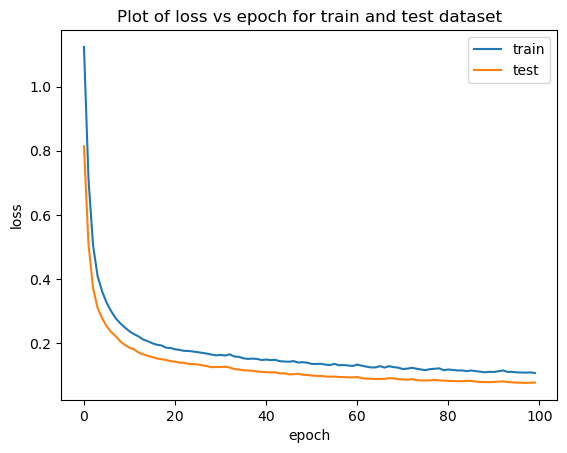

In [119]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [120]:
y_pred_test = model.predict(X_test, batch_size=500)

# For Plot curve
y_pred_evaluation_test = to_categorical(np.argmax(y_pred_test, axis=1), 5)

# For evaluation
y_pred_argmax_test=(np.argmax(y_pred_test, axis=1))

y_test_argmax=(np.argmax(y_test, axis=1))

60/60 [==============================] - 1s 7ms/step


In [121]:
# Calculating Area under the curve
def AUC(actual_class, pred_class, average = "micro"):
    
    #Making a set of all the unique classes 
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #Making a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [123]:
def plot_roc_curve(y_test,y_pred, classes):
    n_classes=len(classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

    plt.plot(fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
           fpr[i],
           tpr[i],
           color=color,
           lw=lw,
        label="ROC curve of {0} (area = {1:0.2f})".format(classes[i], roc_auc[i]),
    )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC")
    plt.legend(loc="lower right")
    plt.show()

In [124]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [125]:
# predicting target attribute on testing dataset
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

929/929 [==============================] - 2s 2ms/step - loss: 0.0766 - accuracy: 0.9732
Test results - Loss: 0.07660660892724991 - Accuracy: 97.32359051704407%


In [126]:
print('AUC Score is on Test : ' , AUC(y_test_argmax, y_pred_argmax_test))

AUC Score is on Test :  {0: 0.9920406216385067, 1: 0.9772437983384322, 2: 0.7933445201880454, 3: 0.7199326122847804, 4: 0.9756303141842203}


In [127]:
from sklearn.metrics import classification_report
classes=['normal', 'Dos','Probe', 'R2L','U2R']

print("Classification Report on Data Test \n" , classification_report(y_test_argmax, y_pred_argmax_test, target_names=classes))

Classification Report on Data Test 
               precision    recall  f1-score   support

      normal       0.99      0.99      0.99     10688
         Dos       0.94      0.96      0.95      2749
       Probe       0.90      0.59      0.71       792
         R2L       0.73      0.44      0.55        25
         U2R       0.97      0.98      0.98     15450

    accuracy                           0.97     29704
   macro avg       0.91      0.79      0.84     29704
weighted avg       0.97      0.97      0.97     29704



Confusion matrix, without normalization


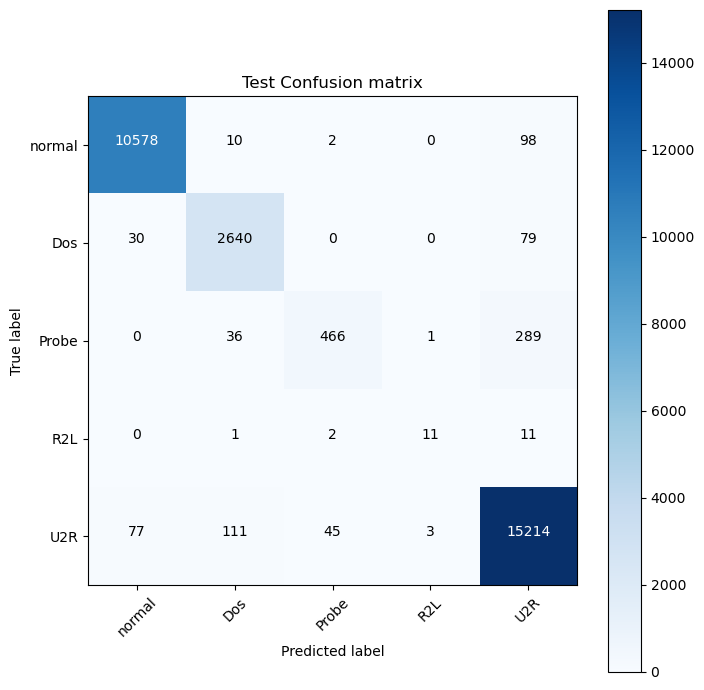

In [128]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test_argmax, y_pred_argmax_test)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7, 7))
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Test Confusion matrix')
plt.show()

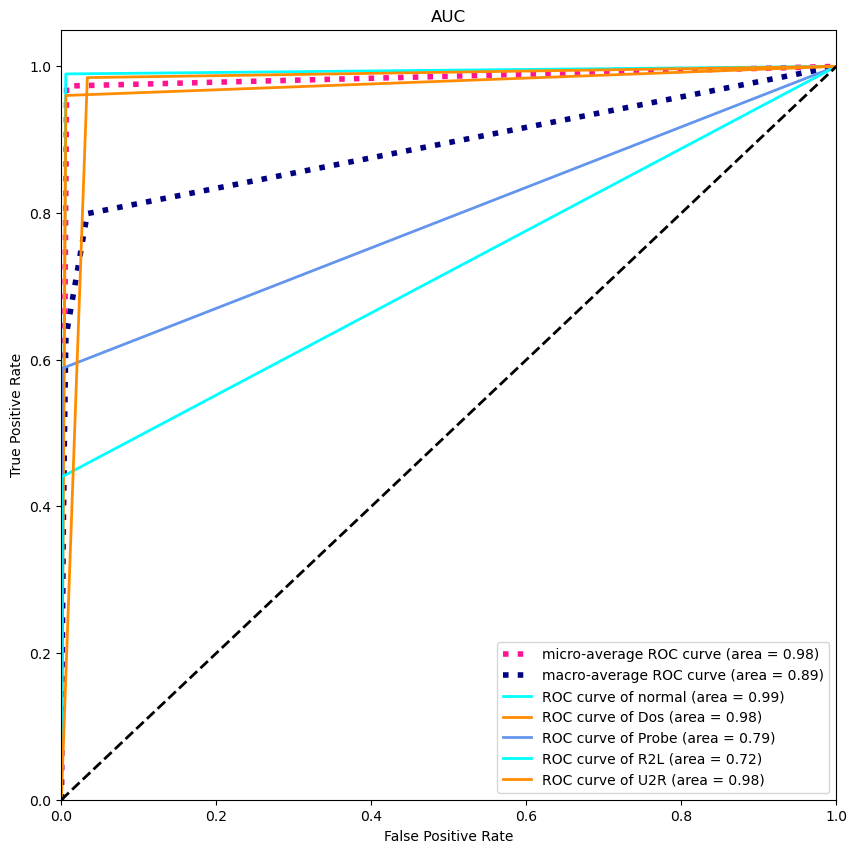

In [129]:
plot_roc_curve(y_test,y_pred_evaluation_test,classes=classes)

In [130]:
model.save("..\models\CNN_NSL-KDD.h5")
model.save("..\models\CNN_NSL-KDD.keras")

c:\Users\youss\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
